In [22]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from pyts.image import GramianAngularField, MarkovTransitionField
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Vision Transformer Function

In [23]:
# Create NumpyDataset class for using with ViT
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data[:, :, :, :3].astype(np.float32) # Select only RGB channel
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [24]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Swap from (Height, Width, Channel) to (Channel, Width, Height)
])

In [25]:
def evaluate(model, dataloader, device):
    model.eval() 
    all_predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) # Get class with the highest probability
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_predictions)

In [26]:
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_test_normalized = np.load('E:/thesis project/thesis_proj/X_test_normalized.npy')
X_train_normalized = np.load('E:/thesis project/thesis_proj/X_train_normalized.npy')
X_train_normalized_aug = np.load('E:/thesis project/thesis_proj/X_train_normalized_aug.npy')
y1_test = np.load('E:/thesis project/thesis_proj/y1_test.npy')
y1_train = np.load('E:/thesis project/thesis_proj/y1_train.npy')
y_train_int_aug = np.load('E:/thesis project/thesis_proj/y_train_int_aug.npy')
# For model
EPOCH = 30
BATCHSIZE = 32
VAL = 0.2
BASE = 'E:/thesis project/thesis_proj/'
PLOTSIZE = 224 # Size of GAF and MTF image
IMAGESIZE = 224 # Size of image loaded from buffer

In [27]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

## Label Encoder

In [28]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

In [29]:
y_train = []

for y in y1_train:
    if y in benign:
        y_train.append('Benign')
    else:
        y_train.append('Ransomware')

In [30]:
y_test = []

for y in y1_test:
    if y in benign:
        y_test.append('Benign')
    else:
        y_test.append('Ransomware')

In [31]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [32]:
lbl = LabelEncoder()

In [33]:
classes, count = np.unique(y_train, return_counts=True)
print(classes)
print(count)

['Benign' 'Ransomware']
[160 672]


In [34]:
print(lbl.fit_transform(classes), classes)
y_train_int = lbl.fit_transform(y_train)
y_train_int.shape

[0 1] ['Benign' 'Ransomware']


(832,)

In [35]:
classes_test, count_test = np.unique(y_test, return_counts=True)
print(classes_test)
print(count_test)

['Benign' 'Ransomware']
[ 41 171]


In [36]:
y_test_int = lbl.transform(y_test)
y_test_int.shape

(212,)

In [37]:
SEED = 42

In [38]:
NUMCLASS = len(classes)

# Image as an Input

In [39]:
PLOTSIZE = 16 # Size of GAF and MTF image
IMAGESIZE = 64 # Size of image loaded from buffer

In [40]:
data_train_transposed = np.transpose(X_train_normalized, (0, 2, 1))
data_train_transposed.shape

(832, 5, 16)

In [41]:
data_train_aug_transposed = np.transpose(X_train_normalized_aug, (0, 2, 1))
data_train_aug_transposed.shape

(1344, 5, 16)

In [42]:
data_test_transposed = np.transpose(X_test_normalized, (0, 2, 1))
data_test_transposed.shape

(212, 5, 16)

## Markov Transition Field

In [43]:
mtf0 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf1 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf2 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf3 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf4 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)

In [44]:
mtf_train_f0 = mtf0.fit_transform(data_train_transposed[:, 0, :])
mtf_train_f1 = mtf1.fit_transform(data_train_transposed[:, 1, :])
mtf_train_f2 = mtf2.fit_transform(data_train_transposed[:, 2, :])
mtf_train_f3 = mtf3.fit_transform(data_train_transposed[:, 3, :])
mtf_train_f4 = mtf4.fit_transform(data_train_transposed[:, 4, :])

In [45]:
mtf_train = np.empty((data_train_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_train[i][j][k] = (mtf_train_f0[i][j][k] + mtf_train_f1[i][j][k] + mtf_train_f2[i][j][k] + mtf_train_f3[i][j][k] + mtf_train_f4[i][j][k])/5

In [46]:
mtf_img_train_tmp = []

for g in mtf_train:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_train_tmp.append(image_array)

In [47]:
mtf_img_train = np.stack(mtf_img_train_tmp, axis=0)
mtf_img_train = mtf_img_train/255
mtf_img_train.shape

(832, 64, 64, 4)

In [48]:
mtf_test_f0 = mtf0.transform(data_test_transposed[:, 0, :])
mtf_test_f1 = mtf1.transform(data_test_transposed[:, 1, :])
mtf_test_f2 = mtf2.transform(data_test_transposed[:, 2, :])
mtf_test_f3 = mtf3.transform(data_test_transposed[:, 3, :])
mtf_test_f4 = mtf4.transform(data_test_transposed[:, 4, :])

In [49]:
mtf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_test[i][j][k] = (mtf_test_f0[i][j][k] + mtf_test_f1[i][j][k] + mtf_test_f2[i][j][k] + mtf_test_f3[i][j][k] + mtf_test_f4[i][j][k])/5

In [50]:
mtf_img_test_tmp = []

for g in mtf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_test_tmp.append(image_array)

In [51]:
mtf_img_test = np.stack(mtf_img_test_tmp, axis=0)
mtf_img_test = mtf_img_test/255
mtf_img_test.shape

(212, 64, 64, 4)

### CNN

In [52]:
tf.random.set_seed(SEED)
cnn_mtf = Sequential(name='CNN_MTF')
cnn_mtf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mtf_img_train.shape[1], mtf_img_train.shape[2], mtf_img_train.shape[3])))
cnn_mtf.add(MaxPooling2D((2, 2)))
cnn_mtf.add(Dropout(0.2))
cnn_mtf.add (Conv2D(16, (3, 3), activation='relu'))
cnn_mtf.add(MaxPooling2D((2, 2)))
cnn_mtf.add(Dropout(0.2))
cnn_mtf.add (Conv2D(8, (3, 3), activation='relu'))
cnn_mtf.add(Flatten())
cnn_mtf.add(Dense(8, activation='relu'))
cnn_mtf.add(Dense(NUMCLASS, activation='softmax'))

cnn_mtf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
cnn_mtf.summary()

Model: "CNN_MTF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         9,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
tf.random.set_seed(SEED)
cnn_mtf_history = cnn_mtf.fit(mtf_img_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7880 - loss: 0.5603 - val_accuracy: 0.8084 - val_loss: 0.4948
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7985 - loss: 0.5159 - val_accuracy: 0.8084 - val_loss: 0.4956
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5088 - val_accuracy: 0.8084 - val_loss: 0.4922
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5051 - val_accuracy: 0.8084 - val_loss: 0.4839
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5040 - val_accuracy: 0.8084 - val_loss: 0.4788
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7985 - loss: 0.5015 - val_accuracy: 0.8084 - val_loss: 0.4718
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5028 - val_accuracy: 0.8084 - val_loss: 0.4700
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7985 - loss: 0.5005 - val_accuracy: 0.8084 - v

In [55]:
cnn_mtf.save(f'{BASE}/Models/cnn_mtf.h5')

### ViT

In [56]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
mtf_train_dataloader = DataLoader(NumpyDataset(mtf_img_train, y_train_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
mtf_test_dataloader = DataLoader(NumpyDataset(mtf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [57]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_mtf = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_mtf.head = nn.Linear(vit_mtf.head.in_features, NUMCLASS)
vit_mtf = vit_mtf.to(device)

In [58]:
for param in vit_mtf.parameters():
    param.requires_grad = False
for param in vit_mtf.head.parameters():
    param.requires_grad = True

In [59]:
total_params = sum(p.numel() for p in vit_mtf.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_mtf.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [60]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mtf.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_mtf.train()
    running_loss = 0

    for inputs, labels in mtf_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_mtf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(mtf_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.5586
Epoch 2/30, Loss: 0.4661
Epoch 3/30, Loss: 0.4500
Epoch 4/30, Loss: 0.4440
Epoch 5/30, Loss: 0.4384
Epoch 6/30, Loss: 0.4342
Epoch 7/30, Loss: 0.4306
Epoch 8/30, Loss: 0.4273
Epoch 9/30, Loss: 0.4244
Epoch 10/30, Loss: 0.4218
Epoch 11/30, Loss: 0.4193
Epoch 12/30, Loss: 0.4170
Epoch 13/30, Loss: 0.4148
Epoch 14/30, Loss: 0.4128
Epoch 15/30, Loss: 0.4108
Epoch 16/30, Loss: 0.4089
Epoch 17/30, Loss: 0.4072
Epoch 18/30, Loss: 0.4054
Epoch 19/30, Loss: 0.4038
Epoch 20/30, Loss: 0.4022
Epoch 21/30, Loss: 0.4006
Epoch 22/30, Loss: 0.3991
Epoch 23/30, Loss: 0.3977
Epoch 24/30, Loss: 0.3963
Epoch 25/30, Loss: 0.3949
Epoch 26/30, Loss: 0.3936
Epoch 27/30, Loss: 0.3923
Epoch 28/30, Loss: 0.3911
Epoch 29/30, Loss: 0.3899
Epoch 30/30, Loss: 0.3887


In [61]:
torch.save(vit_mtf.state_dict(), f'{BASE}/Models/vit_mtf.pth')

### Evaluation

#### CNN

In [62]:
tf.random.set_seed(SEED)
cnn_mtf_pred = cnn_mtf.predict(mtf_img_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [63]:
cnn_mtf_pred_int = np.argmax(cnn_mtf_pred, axis=1)

In [64]:
print('Accuracy:', accuracy_score(y_test_int, cnn_mtf_pred_int))
print('Precision:', precision_score(y_test_int, cnn_mtf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_mtf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_mtf_pred_int, average='macro'))

Accuracy: 0.8066037735849056
Precision: 0.4033018867924528
Recall: 0.5
F1-Score: 0.4464751958224543


C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


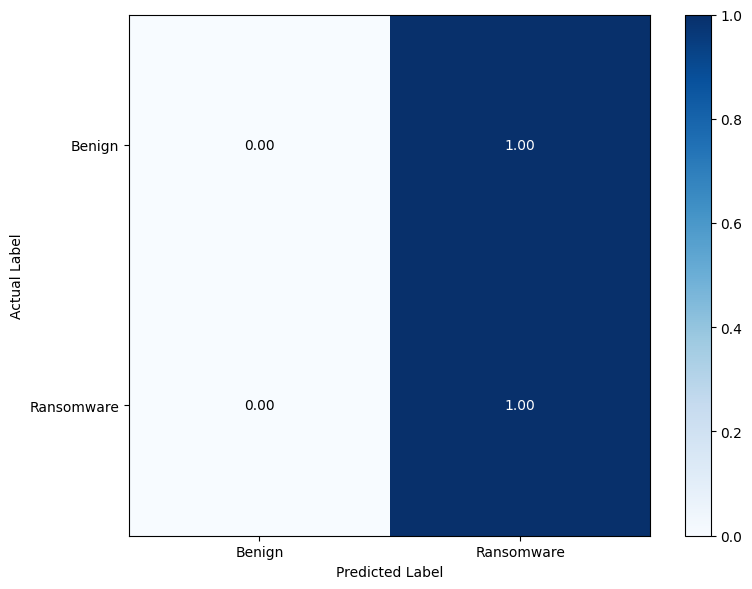

In [65]:
confusionMatrix_cnn_mtf = confusion_matrix(y_test_int, cnn_mtf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_mtf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_mtf.shape[0]):
    for j in range(confusionMatrix_cnn_mtf.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_mtf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_mtf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [66]:
vit_mtf_pred_int = evaluate(vit_mtf, mtf_test_dataloader, device)

In [67]:
print('Accuracy:', accuracy_score(y_test_int, vit_mtf_pred_int))
print('Precision:', precision_score(y_test_int, vit_mtf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_mtf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_mtf_pred_int, average='macro'))

Accuracy: 0.8301886792452831
Precision: 0.7815468113975577
Recall: 0.5887890457851946
F1-Score: 0.6054590570719602


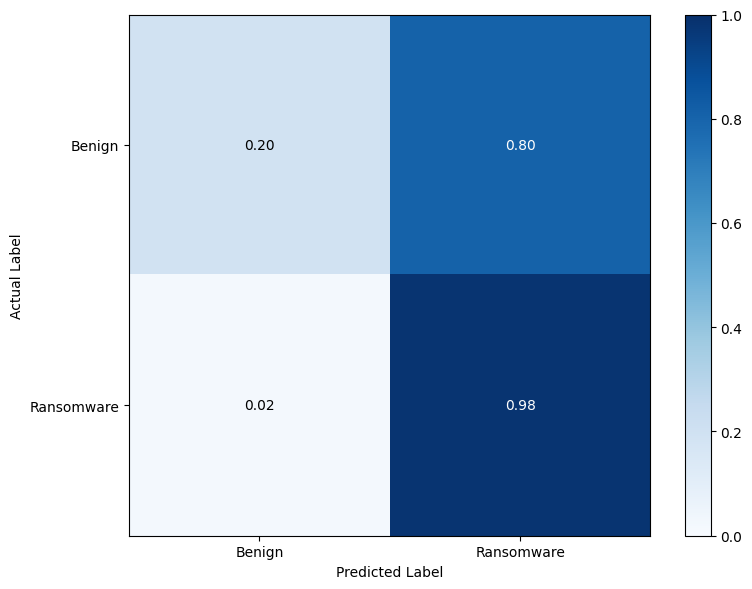

In [68]:
confusionMatrix_vit_mtf = confusion_matrix(y_test_int, vit_mtf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_mtf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_mtf.shape[0]):
    for j in range(confusionMatrix_vit_mtf.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_mtf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_mtf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

### MTF Augmentation

In [69]:
mtf0_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf1_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf2_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf3_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf4_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)

In [70]:
mtf_train_aug_f0 = mtf0_aug.fit_transform(data_train_aug_transposed[:, 0, :])
mtf_train_aug_f1 = mtf1_aug.fit_transform(data_train_aug_transposed[:, 1, :])
mtf_train_aug_f2 = mtf2_aug.fit_transform(data_train_aug_transposed[:, 2, :])
mtf_train_aug_f3 = mtf3_aug.fit_transform(data_train_aug_transposed[:, 3, :])
mtf_train_aug_f4 = mtf4_aug.fit_transform(data_train_aug_transposed[:, 4, :])

In [71]:
mtf_train_aug = np.empty((data_train_aug_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_aug_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_train_aug[i][j][k] = (mtf_train_aug_f0[i][j][k] + mtf_train_aug_f1[i][j][k] + mtf_train_aug_f2[i][j][k] + mtf_train_aug_f3[i][j][k] + mtf_train_aug_f4[i][j][k])/5

In [72]:
mtf_img_train_aug_tmp = []

for g in mtf_train_aug:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_train_aug_tmp.append(image_array)

In [73]:
mtf_img_train_aug = np.stack(mtf_img_train_aug_tmp, axis=0)
mtf_img_train_aug = mtf_img_train_aug/255
mtf_img_train_aug.shape

(1344, 64, 64, 4)

In [74]:
mtf_test_f0 = mtf0_aug.transform(data_test_transposed[:, 0, :])
mtf_test_f1 = mtf1_aug.transform(data_test_transposed[:, 1, :])
mtf_test_f2 = mtf2_aug.transform(data_test_transposed[:, 2, :])
mtf_test_f3 = mtf3_aug.transform(data_test_transposed[:, 3, :])
mtf_test_f4 = mtf4_aug.transform(data_test_transposed[:, 4, :])

In [75]:
mtf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_test[i][j][k] = (mtf_test_f0[i][j][k] + mtf_test_f1[i][j][k] + mtf_test_f2[i][j][k] + mtf_test_f3[i][j][k] + mtf_test_f4[i][j][k])/5

In [76]:
mtf_img_test_tmp = []

for g in mtf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_test_tmp.append(image_array)

In [77]:
mtf_img_test = np.stack(mtf_img_test_tmp, axis=0)
mtf_img_test = mtf_img_test/255
mtf_img_test.shape

(212, 64, 64, 4)

#### CNN with SMOTE

In [78]:
tf.random.set_seed(SEED)
cnn_mtf_aug = Sequential(name='CNN_MTF_aug')
cnn_mtf_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mtf_img_train_aug.shape[1], mtf_img_train_aug.shape[2], mtf_img_train_aug.shape[3])))
cnn_mtf_aug.add(MaxPooling2D((2, 2)))
cnn_mtf_aug.add(Dropout(0.2))
cnn_mtf_aug.add (Conv2D(16, (3, 3), activation='relu'))
cnn_mtf_aug.add(MaxPooling2D((2, 2)))
cnn_mtf_aug.add(Dropout(0.2))
cnn_mtf_aug.add (Conv2D(8, (3, 3), activation='relu'))
cnn_mtf_aug.add(Flatten())
cnn_mtf_aug.add(Dense(8, activation='relu'))
cnn_mtf_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_mtf_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
cnn_mtf_aug.summary()

Model: "CNN_MTF_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         9,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
tf.random.set_seed(SEED)
cnn_mtf_aug_history = cnn_mtf_aug.fit(mtf_img_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5922 - loss: 0.6775 - val_accuracy: 0.0000e+00 - val_loss: 0.9082
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6144 - loss: 0.6714 - val_accuracy: 0.0000e+00 - val_loss: 0.8933
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6144 - loss: 0.6650 - val_accuracy: 0.0000e+00 - val_loss: 0.8635
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6144 - loss: 0.6550 - val_accuracy: 0.0000e+00 - val_loss: 0.9376
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6144 - loss: 0.6488 - val_accuracy: 0.0000e+00 - val_loss: 0.9186
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6138 - loss: 0.6419 - val_accuracy: 0.0149 - val_loss: 0.8853
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6147 - loss: 0.6336 - val_accuracy: 0.0595 - val_loss: 0.8946
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6220 - loss: 0.6290 - val_ac

In [81]:
cnn_mtf_aug.save(f'{BASE}/Models/cnn_mtf_aug.h5')

#### ViT with SMOTE

In [82]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
mtf_train_aug_dataloader = DataLoader(NumpyDataset(mtf_img_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
mtf_test_dataloader = DataLoader(NumpyDataset(mtf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [83]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_mtf_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_mtf_aug.head = nn.Linear(vit_mtf_aug.head.in_features, NUMCLASS)
vit_mtf_aug = vit_mtf_aug.to(device)

In [84]:
for param in vit_mtf_aug.parameters():
    param.requires_grad = False
for param in vit_mtf_aug.head.parameters():
    param.requires_grad = True

In [85]:
total_params = sum(p.numel() for p in vit_mtf_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_mtf_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [86]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mtf_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_mtf_aug.train()
    running_loss = 0

    for inputs, labels in mtf_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_mtf_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(mtf_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.4714
Epoch 2/30, Loss: 2.3759
Epoch 3/30, Loss: 3.3118
Epoch 4/30, Loss: 2.8466
Epoch 5/30, Loss: 2.5874
Epoch 6/30, Loss: 2.4972
Epoch 7/30, Loss: 2.4524
Epoch 8/30, Loss: 2.4177
Epoch 9/30, Loss: 2.3887
Epoch 10/30, Loss: 2.3644
Epoch 11/30, Loss: 2.3438
Epoch 12/30, Loss: 2.3261
Epoch 13/30, Loss: 2.3104
Epoch 14/30, Loss: 2.2964
Epoch 15/30, Loss: 2.2838
Epoch 16/30, Loss: 2.2722
Epoch 17/30, Loss: 2.2615
Epoch 18/30, Loss: 2.2516
Epoch 19/30, Loss: 2.2424
Epoch 20/30, Loss: 2.2337
Epoch 21/30, Loss: 2.2255
Epoch 22/30, Loss: 2.2178
Epoch 23/30, Loss: 2.2105
Epoch 24/30, Loss: 2.2035
Epoch 25/30, Loss: 2.1969
Epoch 26/30, Loss: 2.1905
Epoch 27/30, Loss: 2.1844
Epoch 28/30, Loss: 2.1786
Epoch 29/30, Loss: 2.1730
Epoch 30/30, Loss: 2.1676


In [87]:
torch.save(vit_mtf_aug.state_dict(), f'{BASE}/Models/vit_mtf_aug.pth')

#### Evaluation

##### CNN

In [88]:
tf.random.set_seed(SEED)
cnn_mtf_aug_pred = cnn_mtf_aug.predict(mtf_img_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [89]:
cnn_mtf_aug_pred_int = np.argmax(cnn_mtf_aug_pred, axis=1)

In [90]:
print('Accuracy:', accuracy_score(y_test_int, cnn_mtf_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))

Accuracy: 0.7216981132075472
Precision: 0.5938818565400844
Recall: 0.6142490372272144
F1-Score: 0.5998080307150856


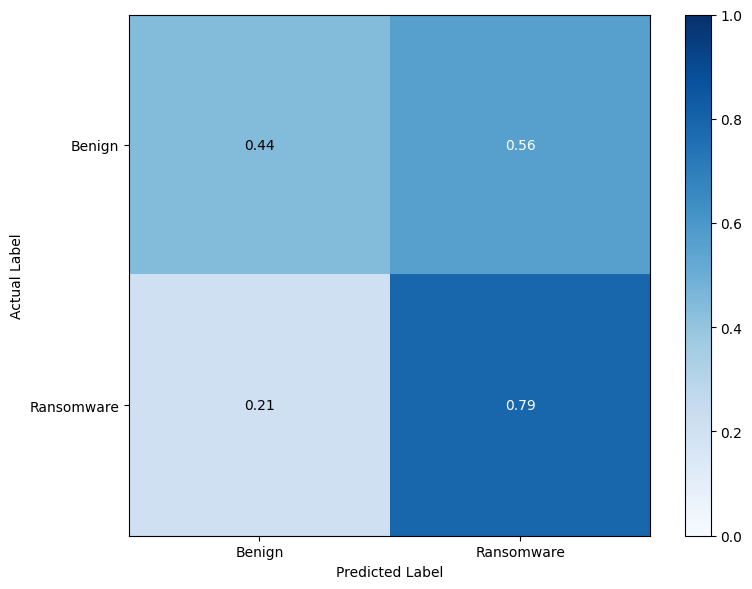

In [91]:
confusionMatrix_cnn_mtf_aug = confusion_matrix(y_test_int, cnn_mtf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_mtf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_mtf_aug.shape[0]):
    for j in range(confusionMatrix_cnn_mtf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_mtf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_mtf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

##### ViT

In [92]:
vit_mtf_aug_pred_int = evaluate(vit_mtf_aug, mtf_test_dataloader, device)

In [93]:
print('Accuracy:', accuracy_score(y_test_int, vit_mtf_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))

Accuracy: 0.19339622641509435
Precision: 0.09669811320754718
Recall: 0.5
F1-Score: 0.16205533596837945


C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


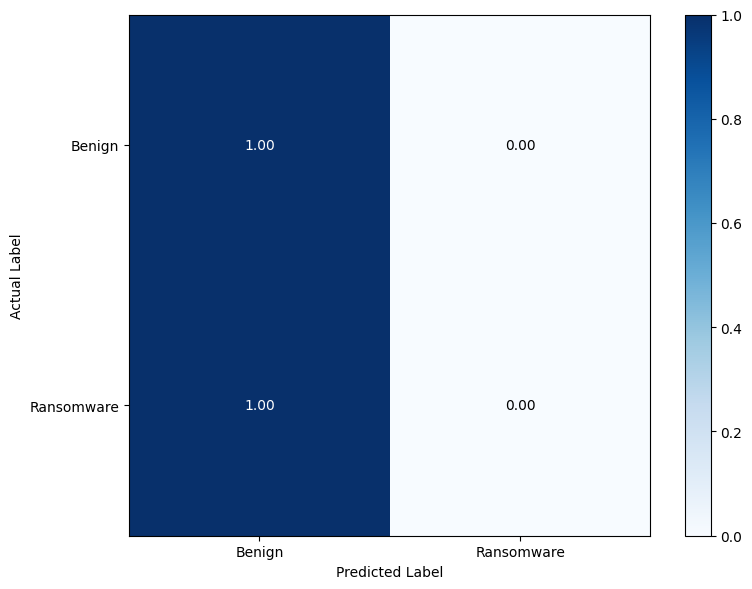

In [94]:
confusionMatrix_vit_mtf_aug = confusion_matrix(y_test_int, vit_mtf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_mtf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_mtf_aug.shape[0]):
    for j in range(confusionMatrix_vit_mtf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_mtf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_mtf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()